In [69]:
import os
import shutil
import datetime
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from log_analyzer import LogAnalyzer


## 0. Run Model 

The below to cells are used to run the model. You can change parameters in the below cell (e.x. `DURATION`, `NUM_MACHINES`, etc.), during the run the results will be in the `logs/` directory. Once all results are done, we move them (including generated plots) in the `past_results/{timestamp}` where `timestamp` is the time that cell is executed (just in case we want to refer to them later)


In [70]:
# Configuration
DURATION = 10
NUM_MACHINES = 3

In [71]:

# Run simulation controller
cmd = ["python", "simulation_controller.py", "-d", str(DURATION), "-m", str(NUM_MACHINES)]
subprocess.run(cmd)

=== Distributed System Simulation with Logical Clocks ===
Initializing 3 virtual machines...
  Machine 1: Port 5000, Clock Rate: 6 ticks/second
  Machine 2: Port 5001, Clock Rate: 5 ticks/second
  Machine 3: Port 5002, Clock Rate: 2 ticks/second
Starting all virtual machines...
2025-03-05 02:18:43.455: Machine 1: Machine started
2025-03-05 02:18:43.455: Machine 2: Machine started
2025-03-05 02:18:43.455: Machine 3: Machine started
Simulation running for 10 seconds...
Stopping all virtual machines...
2025-03-05 02:18:53.520: Machine 1: Machine stopped
2025-03-05 02:18:53.662: Machine 2: Machine stopped
2025-03-05 02:18:54.052: Machine 3: Machine stopped
All machines stopped. Logs are available in the 'logs' directory.


CompletedProcess(args=['python', 'simulation_controller.py', '-d', '10', '-m', '3'], returncode=0)

In [72]:
analyzer = LogAnalyzer()
analyzer.parse_logs()

# Display simulation metadata
duration = analyzer.get_simulation_duration()
print(f"Simulation duration: {duration:.2f} seconds")
print(f"Machine clock rates:")
for machine_id, rate in analyzer.machine_rates.items():
    print(f"  Machine {machine_id}: {rate} ticks/sec")


# Display summary statistics
print("Summary Statistics:")
summary_df = analyzer.analyze_data()
display(summary_df)



Parsing log files from logs...
  Parsed 74 events for Machine 1 (Rate: 6 ticks/sec)
  Parsed 67 events for Machine 2 (Rate: 5 ticks/sec)
  Parsed 36 events for Machine 3 (Rate: 2 ticks/sec)
Simulation duration: 10.43 seconds
Machine clock rates:
  Machine 1: 6 ticks/sec
  Machine 2: 5 ticks/sec
  Machine 3: 2 ticks/sec
Summary Statistics:


,events_count,avg_queue_length,max_queue_length,avg_clock_jump,max_clock_jump,internal_events,send_events,receive_events
1,74.0,0.135135,1.0,1.040541,3.0,31.0,23.0,10.0
2,67.0,0.194030,1.0,1.134328,4.0,27.0,14.0,13.0
3,36.0,0.583333,2.0,1.972222,11.0,5.0,1.0,15.0


## 1. Logical Clock Progression

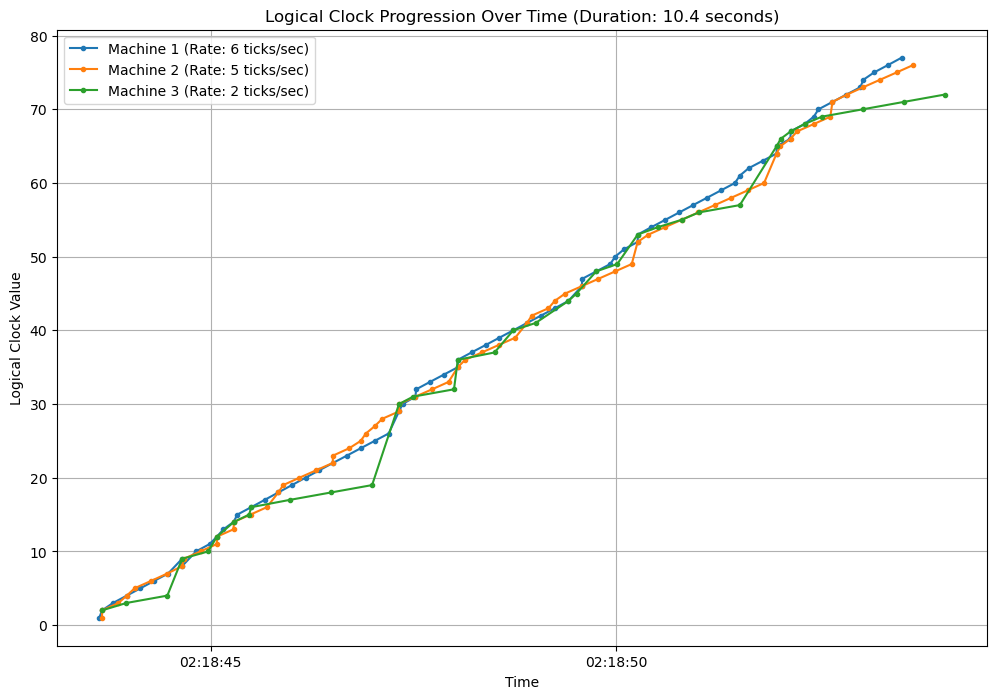

In [73]:
def plot_clock_progression(analyzer):
    """Plot logical clock progression over time for all machines."""
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Get simulation duration for plot title
    duration = analyzer.get_simulation_duration()

    # Create a plot
    plt.figure(figsize=(12, 8))

    # Plot logical clock values over time for each machine
    for machine_id, df in analyzer.log_data.items():
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        plt.plot(
            df["timestamp"],
            df["logical_clock"],
            label=f"Machine {machine_id} (Rate: {clock_rate} ticks/sec)",
            marker="o",
            markersize=3,
            linestyle="-",
        )

    plt.title(
        f"Logical Clock Progression Over Time (Duration: {duration:.1f} seconds)"
    )
    plt.xlabel("Time")
    plt.ylabel("Logical Clock Value")
    plt.legend()
    plt.grid(True)
    plt.savefig("logs/clock_progression.png")
    plt.show()

plot_clock_progression(analyzer)



### Observations on logical clock progression




The machines roughly run at 6, 5, and 2 ticks/sec. Their logical clocks generally increase together with occasional jumps. Machine 3 (slowest at 2 ticks/sec) shows the most irregular progression pattern, while the faster machines (1 and 2) show smoother increases, ending at higher final values around 75-77 ticks compared to Machine 3's ~72 ticks.

## 2. Event distribution

the distribution of event types for each machine.

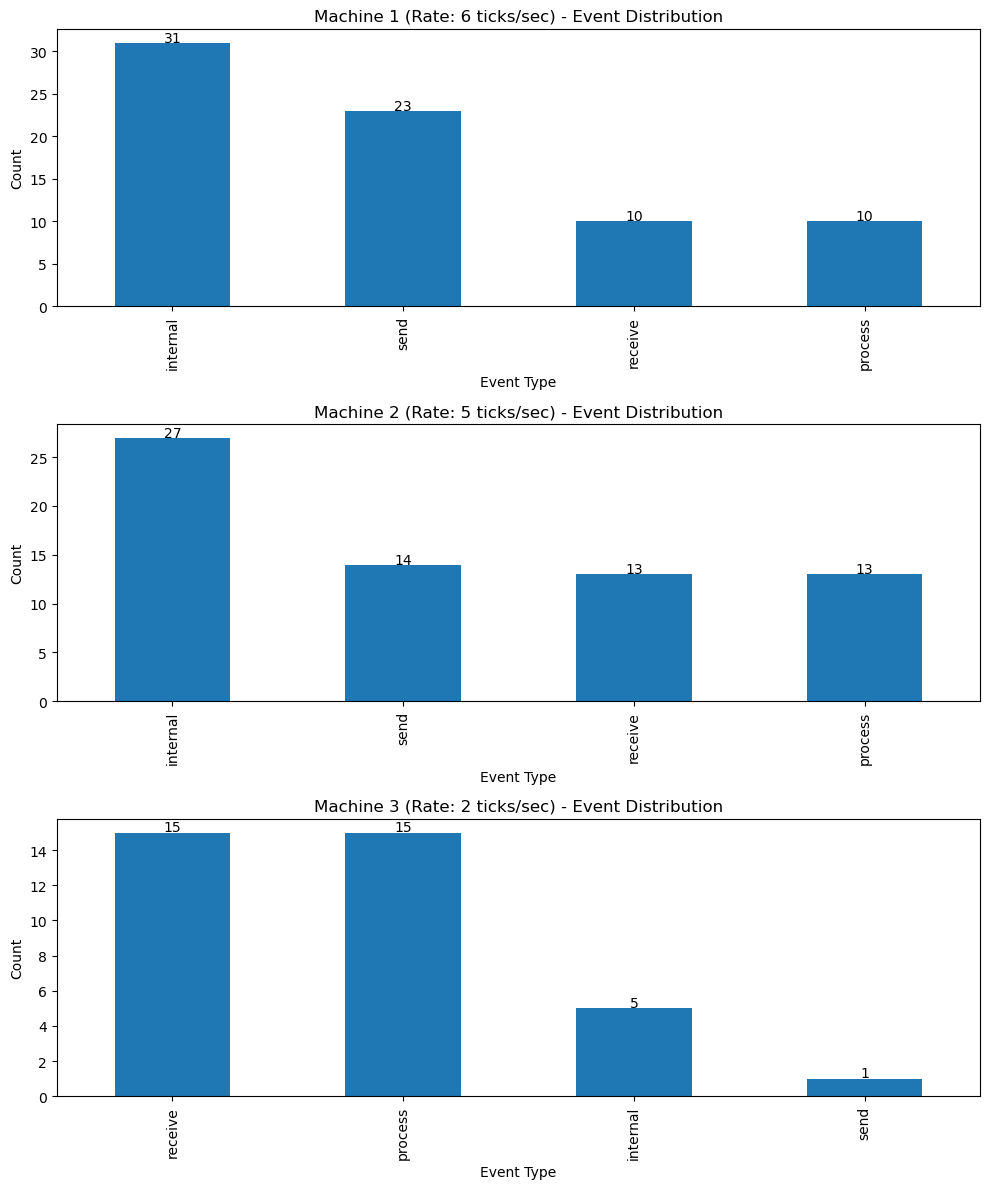

In [74]:
def plot_event_distribution(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Create a figure with subplots for each machine
    fig, axes = plt.subplots(
        len(analyzer.log_data), 1, figsize=(10, 4 * len(analyzer.log_data))
    )

    # If there's only one machine, wrap the axis in a list for consistent indexing
    if len(analyzer.log_data) == 1:
        axes = [axes]

    for i, (machine_id, df) in enumerate(sorted(analyzer.log_data.items())):
        # Count events by type
        event_counts = df["event_type"].value_counts()

        # Create a bar chart
        event_counts.plot(kind="bar", ax=axes[i])
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        axes[i].set_title(
            f"Machine {machine_id} (Rate: {clock_rate} ticks/sec) - Event Distribution"
        )
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Event Type")

        # Add count labels on bars
        for j, count in enumerate(event_counts):
            axes[i].text(j, count + 0.1, str(count), ha="center")

    plt.tight_layout()
    plt.savefig("logs/event_distribution.png")
    plt.show()

plot_event_distribution(analyzer)




### Observations on event distribution


Machine 1 (fastest) mainly does internal events (31) and sends messages (23), with fewer receive and process events (10 each). Machine 2 is similar but more balanced, with 27 internal events and 13-14 of each other type. What's interesting is that Machine 3 (slowest) is mainly receiving and processing (15 each) with very few send events (1), so we think it mainly responds to the faster machines.

## 3. Queue Lengths

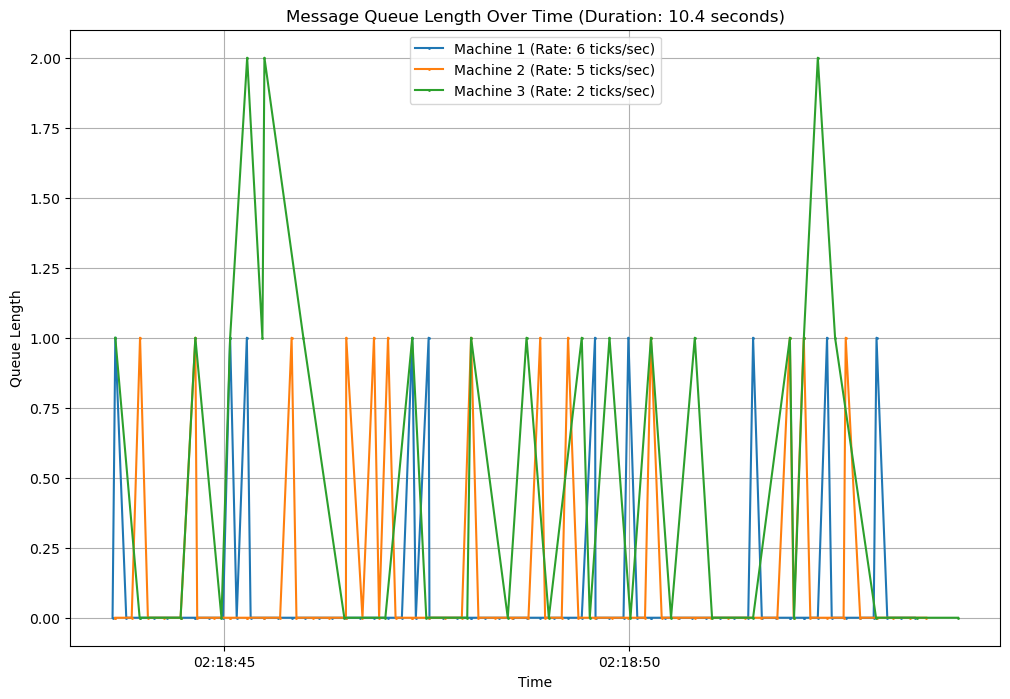

In [75]:
def plot_queue_lengths(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Get simulation duration for plot title
    duration = analyzer.get_simulation_duration()

    # Create a plot
    plt.figure(figsize=(12, 8))

    # Plot queue lengths over time for each machine
    for machine_id, df in analyzer.log_data.items():
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        plt.plot(
            df["timestamp"],
            df["queue_length"],
            label=f"Machine {machine_id} (Rate: {clock_rate} ticks/sec)",
            marker=".",
            markersize=2,
            linestyle="-",
        )

    plt.title(f"Message Queue Length Over Time (Duration: {duration:.1f} seconds)")
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    plt.legend()
    plt.grid(True)
    plt.savefig("logs/queue_lengths.png")
    plt.show()


plot_queue_lengths(analyzer)




### Observations on queue lengths


There are mostly empty queues (0) with occasional spikes to 1 message, so we assume messages are typically processed quickly. Machine 3 (slowest) has two significant queue buildups reaching 2 messages, which is probably when faster machines send multiple messages before it can process them. We think this means our system probably handles message flow efficiently, even thoughh there are rate differences.

## 4 Clock Jumps

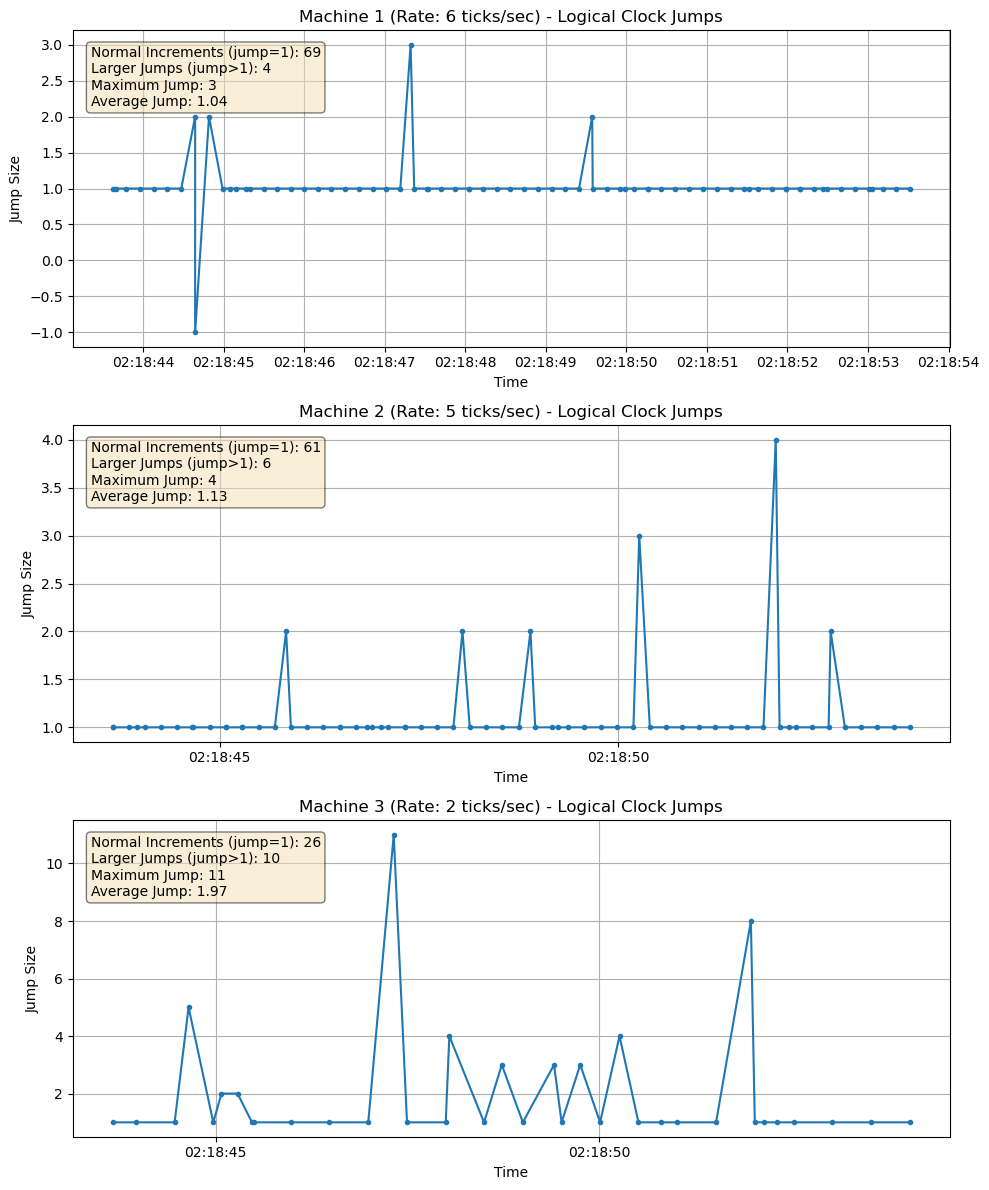

In [76]:
def plot_clock_jumps(analyzer):
    if not analyzer.log_data:
        return "No log data available. Run parse_logs() first."

    # Create a figure with subplots for each machine
    fig, axes = plt.subplots(
        len(analyzer.log_data), 1, figsize=(10, 4 * len(analyzer.log_data))
    )

    if len(analyzer.log_data) == 1:
        axes = [axes]

    for i, (machine_id, df) in enumerate(sorted(analyzer.log_data.items())):
        # Plot clock jumps over time
        clock_rate = analyzer.machine_rates.get(machine_id, "Unknown")
        axes[i].plot(df["timestamp"], df["clock_jump"], marker=".", linestyle="-")
        axes[i].set_title(
            f"Machine {machine_id} (Rate: {clock_rate} ticks/sec) - Logical Clock Jumps"
        )
        axes[i].set_ylabel("Jump Size")
        axes[i].set_xlabel("Time")
        axes[i].grid(True)

        # Add stats as text
        jumps_excluding_ones = df[df["clock_jump"] > 1]["clock_jump"]
        stats_text = (
            f"Normal Increments (jump=1): {len(df[df['clock_jump'] == 1])}\n"
            f"Larger Jumps (jump>1): {len(jumps_excluding_ones)}\n"
            f"Maximum Jump: {df['clock_jump'].max():.0f}\n"
            f"Average Jump: {df['clock_jump'].mean():.2f}"
        )
        axes[i].text(
            0.02,
            0.95,
            stats_text,
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.5},
        )

    plt.tight_layout()
    plt.savefig("logs/clock_jumps.png")
    plt.show()

plot_clock_jumps(analyzer)



###  Observations on clock jumps


Machine 1 (fastest) has mostly normal increments (69) with a handful of larger jumps (4). Machine 2 is similar; it has 61 normal increments (jump size of 1) and 6 larger jumps. Machine 3 (slowest) has the most significant clock corrections, w/ only 26 normal increments and 10 larger jumps (including a max jump of 11 ticks). Slow machines take larger adjustments so they can stay synchronized.

## 5. Maximum Drift

Plot the maximum drift between logical clocks

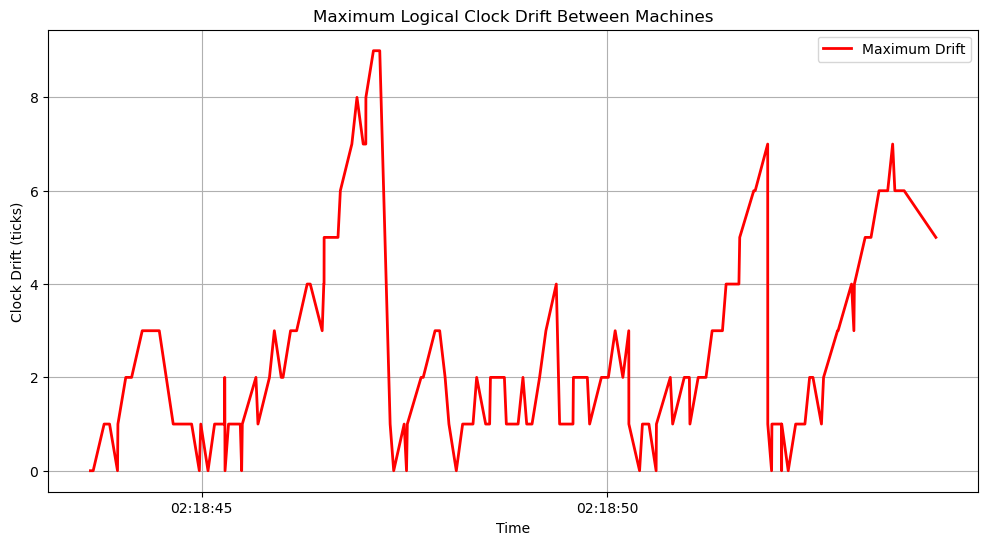

Drift Statistics:
  Mean Drift: 2.44 ticks
  Maximum Drift: 9.00 ticks
  Final Drift: 5.00 ticks


In [77]:
def plot_max_drift(analyzer):
    if not analyzer.log_data or len(analyzer.log_data) < 2:
        return "At least two machines are needed for drift analysis."

    # Sample timestamps at regular intervals
    timestamps = []
    for machine_id, df in analyzer.log_data.items():
        timestamps.extend(df["timestamp"].tolist())

    timestamps = sorted(list(set(timestamps)))

    # Calculate max and min clock values at each timestamp
    drift_data = []
    for ts in timestamps:
        max_clock = 0
        min_clock = float("inf")
        clock_values = {}

        for machine_id, df in analyzer.log_data.items():
            # Find the closest timestamp before or equal to ts
            earlier_events = df[df["timestamp"] <= ts]
            if not earlier_events.empty:
                clock_value = earlier_events.iloc[-1]["logical_clock"]
                max_clock = max(max_clock, clock_value)
                min_clock = min(min_clock, clock_value)
                clock_values[machine_id] = clock_value

        if min_clock != float("inf"):
            drift_data.append(
                {
                    "timestamp": ts,
                    "max_drift": max_clock - min_clock,
                    "clock_values": clock_values,
                }
            )

    # Plot the drift over time
    plt.figure(figsize=(12, 6))

    # Convert to DataFrame for easier plotting
    drift_df = pd.DataFrame(drift_data)

    # Plot max drift
    plt.plot(
        drift_df["timestamp"],
        drift_df["max_drift"],
        label="Maximum Drift",
        color="red",
        linewidth=2,
    )

    plt.title("Maximum Logical Clock Drift Between Machines")
    plt.xlabel("Time")
    plt.ylabel("Clock Drift (ticks)")
    plt.grid(True)
    plt.legend()
    plt.savefig("logs/max_drift.png")
    plt.show()
    
    # Return some statistics about the drift
    return {
        "mean_drift": drift_df["max_drift"].mean(),
        "max_drift": drift_df["max_drift"].max(),
        "final_drift": drift_df["max_drift"].iloc[-1] if not drift_df.empty else None
    }


drift_stats = plot_max_drift(analyzer)
print("Drift Statistics:")
print(f"  Mean Drift: {drift_stats.get('mean_drift', 'N/A'):.2f} ticks")
print(f"  Maximum Drift: {drift_stats.get('max_drift', 'N/A'):.2f} ticks")
print(f"  Final Drift: {drift_stats.get('final_drift', 'N/A'):.2f} ticks")


### Observations on clock drift

We see pretty large drift periods that reach a max of 9 ticks. The mean drift, 2.44 ticks, probably indicates good synchronization in general, with the occasional divergence. The last drift of 5 ticks tells us that the system ended with clocks out of sync, to a moderate extent. Ultimately we see cycles in the drift pattern, where there's increasing divergence that leads to correction, showing that there's tension btwn independent clock rates and the ways the system attempts to synch.

## Save This Run's Results 

In [78]:
# Get current time and format it
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create destination directory
dest_dir = os.path.join("past_results", now)
os.makedirs(dest_dir, exist_ok=True)

# Move files from logs to destination
for file in os.listdir("logs"):
    src_path = os.path.join("logs", file)
    dst_path = os.path.join(dest_dir, file)
    shutil.move(src_path, dst_path)

print(f"Moved log files to {dest_dir}")

Moved log files to past_results/2025-03-05_02-18-55


### Summary and conclusions
	1.	Overall system behavior
	Each VM operated independently w/ its own clock rate (ranging from 1 to 6 ticks per second) and maintained a local Lamport logical clock. Messages were exchanged with TCP sockets, asynch . Each VM logged all send, receive, and internal events so we could track logs.
	The logical clocks overall successfully maintained a logical ordering of events. Generally, the machines accurately updated their logical clocks in response to internal events and incoming messages, which preserved causality even w/ asynch communication.

	2.	Diff clock rates
	Machines running at faster clock rates incremented their logical clocks more frequently, which led to comparatively higher clock values. This sometimes caused messages to arrive with seemingly “older” timestamps at slower machines, triggering clock corrections (like taking the max of the local clock and the received timestamp, then incrementing).

	For message queueing and processing, all messages were placed into a thread-safe queue. Machines running at higher clock rates tended to generate more frequent events (so more messages) which sometimes caused brief spikes in queue length on receiving machines. But the asynchronous nature of communication still allowed the system to adapt and process messages w/o major deadlocks or loss of data.

	3.	Impl effectiveness
 	Following Lamport's rules, we increment on internal events, and on message receipt, set the clock to the max of local and received values and then increment. This makes sure that a receiving machine’s logical clock always advances to reflect new causal information.

	4.	Takeaways, what we learned

	We realized logging was important early on to figure out bugs
	We considered scalability: we realize that this handling and message proessing might create bottlenecks w/ more messages, and that this would need to be optimized for a larger system